This notebook is considered part-2 of LSTM Model V3, you shall upload the created folder in part 1 manually to your google drive, and follow below steps with necessary adjustments in order to have LSTM Model V3

below LSTM model had very low scores, further enhancements can be done to raise the overall performance

This notebook can only run in Coolab Pro utilizing the available TPU

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import os
from google.colab import drive
import zipfile
import shutil
import glob
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.mixed_precision import set_global_policy
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [2]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#extract the LSTM_Seq zip file

# Navigate to your uploaded file location
drive_path = '/content/drive/My Drive/Colab Notebooks/LSTM_Seq.zip'  # Adjust this path to match your upload
output_dir = '/content/LSTM_Seq/'

# Extract the zip file
os.makedirs(output_dir, exist_ok=True)
with zipfile.ZipFile(drive_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"Files extracted to {output_dir}")


Files extracted to /content/LSTM_Seq/


In [5]:

nested_dir = "/content/LSTM_Seq/LSTM_Seq"
if os.path.exists(nested_dir):
    print(f"Files in {nested_dir}:")
    print(os.listdir(nested_dir))
else:
    print("No nested directory found.")


Files in /content/LSTM_Seq/LSTM_Seq:
['train_X_1718000.npy', 'train_y_16031000.npy', 'test_X_1873000.npy', 'train_X_6663000.npy', 'test_X_719000.npy', 'train_y_3538000.npy', 'train_y_2062000.npy', 'train_y_9310000.npy', 'train_y_10224000.npy', 'train_y_7072000.npy', 'train_X_9501000.npy', 'train_y_219000.npy', 'test_y_949000.npy', 'train_X_16107000.npy', 'train_y_14885000.npy', 'train_X_13728000.npy', 'train_X_778000.npy', 'train_y_7931000.npy', 'test_X_3786000.npy', 'train_X_12337000.npy', 'test_X_3861000.npy', 'train_y_16285000.npy', 'train_y_12955000.npy', 'test_y_2242000.npy', 'train_X_10693000.npy', 'train_X_4203000.npy', 'test_X_697000.npy', 'train_y_7150000.npy', 'train_y_16013000.npy', 'train_y_2198000.npy', 'train_X_9468000.npy', 'train_X_3090000.npy', 'train_y_4428000.npy', 'test_X_3288000.npy', 'train_y_9810000.npy', 'train_X_824000.npy', 'train_X_1508000.npy', 'train_X_11188000.npy', 'train_X_8894000.npy', 'train_y_1963000.npy', 'train_y_8873000.npy', 'test_y_131000.npy', '

In [6]:

nested_dir = "/content/LSTM_Seq/LSTM_Seq"
output_dir = "/content/LSTM_Seq"

# Move all files from nested_dir to output_dir
if os.path.exists(nested_dir):
    for file_name in os.listdir(nested_dir):
        shutil.move(os.path.join(nested_dir, file_name), output_dir)

    # Remove the now-empty nested directory
    shutil.rmtree(nested_dir)

print(f"Files after moving:")
print(os.listdir(output_dir))


Files after moving:
['train_X_1718000.npy', 'train_y_16031000.npy', 'test_X_1873000.npy', 'train_X_6663000.npy', 'test_X_719000.npy', 'train_y_3538000.npy', 'train_y_2062000.npy', 'train_y_9310000.npy', 'train_y_10224000.npy', 'train_y_7072000.npy', 'train_X_9501000.npy', 'train_y_219000.npy', 'test_y_949000.npy', 'train_X_16107000.npy', 'train_y_14885000.npy', 'train_X_13728000.npy', 'train_X_778000.npy', 'train_y_7931000.npy', 'test_X_3786000.npy', 'train_X_12337000.npy', 'test_X_3861000.npy', 'train_y_16285000.npy', 'train_y_12955000.npy', 'test_y_2242000.npy', 'train_X_10693000.npy', 'train_X_4203000.npy', 'test_X_697000.npy', 'train_y_7150000.npy', 'train_y_16013000.npy', 'train_y_2198000.npy', 'train_X_9468000.npy', 'train_X_3090000.npy', 'train_y_4428000.npy', 'test_X_3288000.npy', 'train_y_9810000.npy', 'train_X_824000.npy', 'train_X_1508000.npy', 'train_X_11188000.npy', 'train_X_8894000.npy', 'train_y_1963000.npy', 'train_y_8873000.npy', 'test_y_131000.npy', 'train_y_4031000.n

In [2]:


def load_batches_from_dir(output_dir, output_prefix):
    """
    Load all .npy files with the given prefix from the specified directory.
    """
    X_files = sorted(glob.glob(os.path.join(output_dir, f"{output_prefix}_X_*.npy")))
    y_files = sorted(glob.glob(os.path.join(output_dir, f"{output_prefix}_y_*.npy")))

    X = np.concatenate([np.load(f) for f in X_files], axis=0)
    y = np.concatenate([np.load(f) for f in y_files], axis=0)

    return X, y

# Load train and test datasets
output_dir = "/content/LSTM_Seq/"
X_train, y_train = load_batches_from_dir(output_dir, "train")
X_test, y_test = load_batches_from_dir(output_dir, "test")

# Verify shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (18096012, 60, 5), y_train shape: (18096012,)
X_test shape: (3973708, 60, 5), y_test shape: (3973708,)


In [3]:
#step 4

# Map class labels to zero-indexed values
unique_classes = sorted(np.unique(y_train))  # Find unique classes in sorted order
class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}  # Map original class to new index

# Apply the mapping
y_train_mapped = np.array([class_mapping[label] for label in y_train])
y_test_mapped = np.array([class_mapping[label] for label in y_test])

# One-hot encode the remapped labels
num_classes = len(unique_classes)  # Total number of unique classes
y_train_encoded = to_categorical(y_train_mapped, num_classes=num_classes)
y_test_encoded = to_categorical(y_test_mapped, num_classes=num_classes)

# Verify the shapes
print(f"y_train_encoded shape: {y_train_encoded.shape}, y_test_encoded shape: {y_test_encoded.shape}")
print(f"Class mapping: {class_mapping}")


y_train_encoded shape: (18096012, 4), y_test_encoded shape: (3973708, 4)
Class mapping: {0: 0, 101: 1, 105: 2, 107: 3}


In [4]:

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    print(f"Running on TPU: {tpu.master()}")
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)  # Create a strategy
except ValueError as e:
    print("TPU not found. Falling back to CPU/GPU.")
    print("Error:", e)
    strategy = tf.distribute.get_strategy()

print("Number of replicas in sync:", strategy.num_replicas_in_sync)


Running on TPU: 
Number of replicas in sync: 8


In [7]:

# Reset precision policy to float32 for TPU compatibility
set_global_policy('float32')

# Verify the current precision policy
print("Current precision policy:", tf.keras.mixed_precision.global_policy())

# Use TensorFlow Dataset for efficient data pipeline
batch_size = 1000  # Adjust based on TPU capabilities
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_encoded))
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_encoded))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# TPU setup
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    print('Running on TPU:', tpu.master())

    # Initialize only if TPU is not already initialized
    if not tf.config.list_logical_devices('TPU'):
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.TPUStrategy(tpu)  # Create a strategy
except ValueError as e:
    print("TPU not found. Falling back to CPU/GPU.")
    print("Error:", e)
    strategy = tf.distribute.get_strategy()

print("Number of replicas in sync:", strategy.num_replicas_in_sync)

# Define the LSTM model within the TPU strategy scope
with strategy.scope():
    model = Sequential([
        LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for efficient training
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_tpu.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)


Current precision policy: <Policy "float32">
Running on TPU: 
Number of replicas in sync: 8
Epoch 1/50
18097/18097 [==============================] - 492s 27ms/step - loss: 0.3361 - accuracy: 0.9014 - val_loss: 1.9030 - val_accuracy: 0.3187 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
18097/18097 [==============================] - 476s 26ms/step - loss: 0.2726 - accuracy: 0.9152 - val_loss: 1.4779 - val_accuracy: 0.4975 - lr: 0.0010
Epoch 3/50
18097/18097 [==============================] - 481s 27ms/step - loss: 0.3372 - accuracy: 0.8938 - val_loss: 2.0387 - val_accuracy: 0.2514 - lr: 0.0010
Epoch 4/50
18097/18097 [==============================] - 477s 26ms/step - loss: 0.3290 - accuracy: 0.8953 - val_loss: 2.3542 - val_accuracy: 0.3877 - lr: 0.0010
Epoch 5/50
18097/18097 [==============================] - 478s 26ms/step - loss: 0.3443 - accuracy: 0.8970 - val_loss: 2.0113 - val_accuracy: 0.4900 - lr: 0.0010


In [8]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 1.4781, Test Accuracy: 0.4975


In [10]:

# Define the batch size for evaluation
batch_size = 2048  # Adjust this value based on memory availability

# Create the test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_encoded))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [11]:
# Predict probabilities for the test set
y_pred_probs = model.predict(test_dataset)

# Convert probabilities to predicted classes
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels from the test dataset
y_true = np.argmax(y_test_encoded, axis=1)


1941/1941 [==============================] - 37s 13ms/step


In [12]:

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[str(cls) for cls in unique_classes]))


Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.78      0.35      0.48   1369753
         101       0.40      0.94      0.56   1164386
         105       0.00      0.00      0.00    440719
         107       0.62      0.41      0.49    998850

    accuracy                           0.50   3973708
   macro avg       0.45      0.42      0.38   3973708
weighted avg       0.54      0.50      0.46   3973708



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


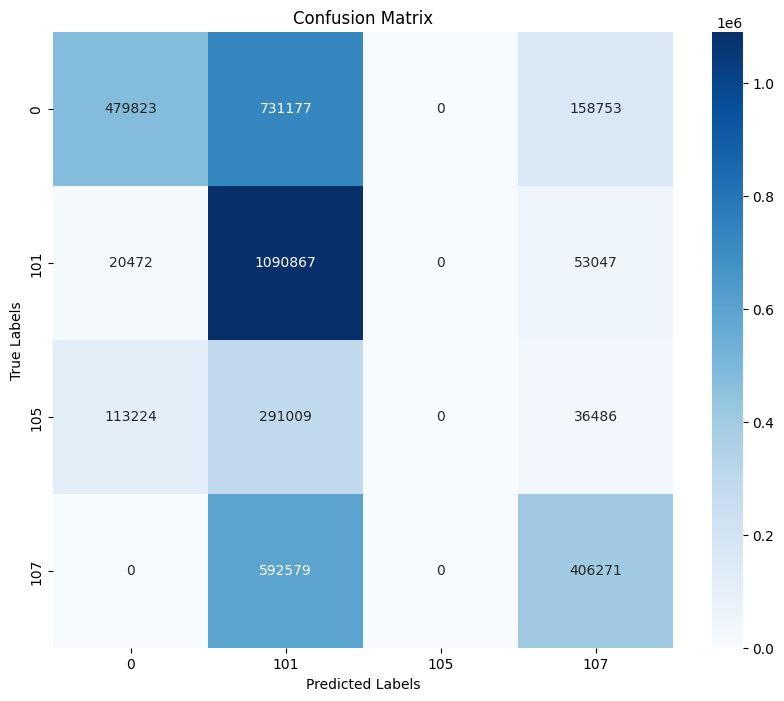

In [13]:

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [14]:

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall: {recall:.4f}")
print(f"Overall F1-Score: {f1:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Overall Precision: 0.5437
Overall Recall: 0.4975
Overall F1-Score: 0.4555
Overall Accuracy: 0.4975
